# Large-Scale Pretrained Audio Neural Networks Autoencoder for DCASE‑Inspired Anomalous Sound Detection


In [2]:
# Install dependencies if needed
# !pip install torch torchvision torchaudio librosa tqdm scikit-learn

In [3]:
import os, glob, random, numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm


## Data Prep & PANN Embedding Extraction

In [4]:
TRAIN_WAV = 'DATA/dev_data/dev_data/slider/train'
TEST_WAV  = 'DATA/dev_data/dev_data/slider/test'
EMB_DIR   = 'DATA/embeddings_panns'
os.makedirs(f'{EMB_DIR}/train', exist_ok=True)
os.makedirs(f'{EMB_DIR}/test',  exist_ok=True)

# Import PANNs Inference API
from panns_inference import AudioTagging

# Initialize AudioTagging (uses pretrained CNN14_16k under the hood)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
at = AudioTagging(checkpoint_path=None, device=DEVICE)

# Function to extract and save embeddings from PANNs
import torchaudio.functional as Ffunc

def extract_save(wav_list, split):
    out_dir = os.path.join(EMB_DIR, split)
    for wav in tqdm(wav_list, desc=f'Extract {split}', leave=False):
        name = os.path.basename(wav).replace('.wav', '.npy')
        out_path = os.path.join(out_dir, name)
        if os.path.exists(out_path):
            continue
        y, sr = torchaudio.load(wav)
        # PANNs Inference expects 32 kHz
        if sr != 32000:
            y = Ffunc.resample(y, sr, 32000)
        # to numpy batch
        y_np = y.squeeze(0).cpu().numpy()[None, :]
        # get clipwise embedding
        _, emb = at.inference(y_np)
        emb = emb[0]  # shape: [2048]
        np.save(out_path, emb)

# Run extraction on train & test sets
train_files = sorted(glob.glob(os.path.join(TRAIN_WAV, '*.wav')))
test_files  = sorted(glob.glob(os.path.join(TEST_WAV,  '*.wav')))
extract_save(train_files, 'train')
extract_save(test_files,  'test')

Checkpoint path: C:\Users\dell/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


## Dataset & DataLoader

In [5]:
class PannsDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # [2048]
        x = torch.tensor(arr, dtype=torch.float32)
        label = 0 if 'normal' in self.files[idx].lower() else 1
        return x, label
BATCH=512
train_ds = PannsDataset(f'{EMB_DIR}/train')
test_ds  = PannsDataset(f'{EMB_DIR}/test')
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0)

## Fully‑Connected Autoencoder on PANN Embeddings

In [15]:
import torch
import torch.nn as nn

class FCUnetAE(nn.Module):
    def __init__(self,
                 input_dim=2048,
                 hidden_dims=(1024, 512, 256),
                 latent_dim=128,
                 dropout=0.2):
        super().__init__()
        # 1) Encoder
        enc_dims = [input_dim] + list(hidden_dims)
        self.enc_layers = nn.ModuleList()
        for in_d, out_d in zip(enc_dims[:-1], enc_dims[1:]):
            self.enc_layers.append(nn.Sequential(
                nn.Linear(in_d, out_d),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
            ))

        # 2) Bottleneck (compress → expand back)
        self.bottleneck = nn.Sequential(
            nn.Linear(hidden_dims[-1], latent_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(latent_dim, hidden_dims[-1]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )

        # 3) Decoder: for each skip-connection, cat then map back
        #    We build one Linear per skip, plus a final Linear back to input_dim.
        skips = hidden_dims  # [1024, 512, 256]
        dec_in_dims = []
        dec_out_dims = []

        x_dim = hidden_dims[-1]  # start from bottleneck output (256)
        for skip_dim in reversed(skips):
            dec_in_dims.append(x_dim + skip_dim)
            dec_out_dims.append(skip_dim)
            x_dim = skip_dim

        # final step: map back from x_dim (=hidden_dims[0]=1024) → input_dim
        dec_in_dims.append(x_dim)
        dec_out_dims.append(input_dim)

        self.dec_layers = nn.ModuleList()
        for in_d, out_d in zip(dec_in_dims, dec_out_dims):
            # use Identity at the very end (no ReLU), else ReLU
            act = nn.Identity() if out_d == input_dim else nn.ReLU(inplace=True)
            self.dec_layers.append(nn.Sequential(
                nn.Linear(in_d, out_d),
                act
            ))

    def forward(self, x):
        # x: [B, 2048]
        skips = []
        for enc in self.enc_layers:
            x = enc(x)
            skips.append(x)

        x = self.bottleneck(x)

        # Decoder: use skips in reverse order
        for dec, skip in zip(self.dec_layers[:-1], reversed(skips)):
            x = torch.cat([x, skip], dim=1)
            x = dec(x)

        # final layer (no skip)
        x = self.dec_layers[-1](x)
        return x

# Example instantiation
model = FCUnetAE(
    input_dim=2048,
    hidden_dims=(1024, 512, 256),
    latent_dim=128,
    dropout=0.2
).to(DEVICE)

print(model)


FCUnetAE(
  (enc_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (bottleneck): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
  )
  (dec_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0)

## Training Loop

In [16]:
# Hyperparameters
LR = 1e-3
EPOCHS = 500
PATIENCE = 20  # early stopping patience
MIN_DELTA = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
# Reduce LR on plateau if loss saturates
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20, 
)

# DataLoaders
# train_dl, test_dl, train_ds should be defined elsewhere

# Training loop with early stopping & checkpointing
best_loss = float('inf')
no_improve = 0
history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}"):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)

    epoch_loss = running_loss / len(train_ds)
    history.append(epoch_loss)
    print(f"Epoch {epoch} Loss: {epoch_loss:.6f}")

    # Scheduler step on loss plateau
    scheduler.step(epoch_loss)

    # Early stopping check
    if best_loss - epoch_loss > MIN_DELTA:
        best_loss = epoch_loss
        no_improve = 0
        # Save best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }, 'best_model.pt')
        print(f"--> New best model saved at epoch {epoch} with loss {epoch_loss:.6f}")
    else:
        no_improve += 1
        print(f"No improvement for {no_improve}/{PATIENCE} epochs.")
        if no_improve >= PATIENCE:
            print(f"Stopping early at epoch {epoch} due to no improvement.")
            break


Epoch 1/500: 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch 1 Loss: 0.034790
--> New best model saved at epoch 1 with loss 0.034790


Epoch 2/500: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]


Epoch 2 Loss: 0.013071
--> New best model saved at epoch 2 with loss 0.013071


Epoch 3/500: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]


Epoch 3 Loss: 0.010077
--> New best model saved at epoch 3 with loss 0.010077


Epoch 4/500: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


Epoch 4 Loss: 0.008555
--> New best model saved at epoch 4 with loss 0.008555


Epoch 5/500: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 5 Loss: 0.007155
--> New best model saved at epoch 5 with loss 0.007155


Epoch 6/500: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch 6 Loss: 0.006146
--> New best model saved at epoch 6 with loss 0.006146


Epoch 7/500: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


Epoch 7 Loss: 0.005262
--> New best model saved at epoch 7 with loss 0.005262


Epoch 8/500: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 8 Loss: 0.004700
--> New best model saved at epoch 8 with loss 0.004700


Epoch 9/500: 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Epoch 9 Loss: 0.004270
--> New best model saved at epoch 9 with loss 0.004270


Epoch 10/500: 100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


Epoch 10 Loss: 0.003867
--> New best model saved at epoch 10 with loss 0.003867


Epoch 11/500: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch 11 Loss: 0.003565
--> New best model saved at epoch 11 with loss 0.003565


Epoch 12/500: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch 12 Loss: 0.003395
--> New best model saved at epoch 12 with loss 0.003395


Epoch 13/500: 100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch 13 Loss: 0.003243
--> New best model saved at epoch 13 with loss 0.003243


Epoch 14/500: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


Epoch 14 Loss: 0.003097
--> New best model saved at epoch 14 with loss 0.003097


Epoch 15/500: 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]


Epoch 15 Loss: 0.002979
--> New best model saved at epoch 15 with loss 0.002979


Epoch 16/500: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]


Epoch 16 Loss: 0.002958
No improvement for 1/20 epochs.


Epoch 17/500: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch 17 Loss: 0.002792
--> New best model saved at epoch 17 with loss 0.002792


Epoch 18/500: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Epoch 18 Loss: 0.002698
No improvement for 1/20 epochs.


Epoch 19/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 19 Loss: 0.002571
--> New best model saved at epoch 19 with loss 0.002571


Epoch 20/500: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


Epoch 20 Loss: 0.002478
No improvement for 1/20 epochs.


Epoch 21/500: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 21 Loss: 0.002376
--> New best model saved at epoch 21 with loss 0.002376


Epoch 22/500: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


Epoch 22 Loss: 0.002284
No improvement for 1/20 epochs.


Epoch 23/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 23 Loss: 0.002216
--> New best model saved at epoch 23 with loss 0.002216


Epoch 24/500: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Epoch 24 Loss: 0.002146
No improvement for 1/20 epochs.


Epoch 25/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 25 Loss: 0.002079
--> New best model saved at epoch 25 with loss 0.002079


Epoch 26/500: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 26 Loss: 0.002012
No improvement for 1/20 epochs.


Epoch 27/500: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


Epoch 27 Loss: 0.001957
--> New best model saved at epoch 27 with loss 0.001957


Epoch 28/500: 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Epoch 28 Loss: 0.001915
No improvement for 1/20 epochs.


Epoch 29/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 29 Loss: 0.001846
--> New best model saved at epoch 29 with loss 0.001846


Epoch 30/500: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


Epoch 30 Loss: 0.001800
No improvement for 1/20 epochs.


Epoch 31/500: 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]


Epoch 31 Loss: 0.001748
No improvement for 2/20 epochs.


Epoch 32/500: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


Epoch 32 Loss: 0.001706
--> New best model saved at epoch 32 with loss 0.001706


Epoch 33/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 33 Loss: 0.001674
No improvement for 1/20 epochs.


Epoch 34/500: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch 34 Loss: 0.001623
No improvement for 2/20 epochs.


Epoch 35/500: 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Epoch 35 Loss: 0.001600
--> New best model saved at epoch 35 with loss 0.001600


Epoch 36/500: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


Epoch 36 Loss: 0.001559
No improvement for 1/20 epochs.


Epoch 37/500: 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]


Epoch 37 Loss: 0.001541
No improvement for 2/20 epochs.


Epoch 38/500: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]


Epoch 38 Loss: 0.001507
No improvement for 3/20 epochs.


Epoch 39/500: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]


Epoch 39 Loss: 0.001480
--> New best model saved at epoch 39 with loss 0.001480


Epoch 40/500: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 40 Loss: 0.001448
No improvement for 1/20 epochs.


Epoch 41/500: 100%|██████████| 5/5 [00:00<00:00,  6.33it/s]


Epoch 41 Loss: 0.001438
No improvement for 2/20 epochs.


Epoch 42/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 42 Loss: 0.001410
No improvement for 3/20 epochs.


Epoch 43/500: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]


Epoch 43 Loss: 0.001383
No improvement for 4/20 epochs.


Epoch 44/500: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


Epoch 44 Loss: 0.001370
--> New best model saved at epoch 44 with loss 0.001370


Epoch 45/500: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


Epoch 45 Loss: 0.001362
No improvement for 1/20 epochs.


Epoch 46/500: 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]


Epoch 46 Loss: 0.001339
No improvement for 2/20 epochs.


Epoch 47/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 47 Loss: 0.001318
No improvement for 3/20 epochs.


Epoch 48/500: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 48 Loss: 0.001300
No improvement for 4/20 epochs.


Epoch 49/500: 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Epoch 49 Loss: 0.001289
No improvement for 5/20 epochs.


Epoch 50/500: 100%|██████████| 5/5 [00:00<00:00,  6.24it/s]


Epoch 50 Loss: 0.001265
--> New best model saved at epoch 50 with loss 0.001265


Epoch 51/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 51 Loss: 0.001249
No improvement for 1/20 epochs.


Epoch 52/500: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


Epoch 52 Loss: 0.001238
No improvement for 2/20 epochs.


Epoch 53/500: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 53 Loss: 0.001228
No improvement for 3/20 epochs.


Epoch 54/500: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]


Epoch 54 Loss: 0.001214
No improvement for 4/20 epochs.


Epoch 55/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 55 Loss: 0.001200
No improvement for 5/20 epochs.


Epoch 56/500: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]


Epoch 56 Loss: 0.001187
No improvement for 6/20 epochs.


Epoch 57/500: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 57 Loss: 0.001202
No improvement for 7/20 epochs.


Epoch 58/500: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


Epoch 58 Loss: 0.001172
No improvement for 8/20 epochs.


Epoch 59/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 59 Loss: 0.001175
No improvement for 9/20 epochs.


Epoch 60/500: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


Epoch 60 Loss: 0.001160
--> New best model saved at epoch 60 with loss 0.001160


Epoch 61/500: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


Epoch 61 Loss: 0.001144
No improvement for 1/20 epochs.


Epoch 62/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 62 Loss: 0.001128
No improvement for 2/20 epochs.


Epoch 63/500: 100%|██████████| 5/5 [00:00<00:00,  6.02it/s]


Epoch 63 Loss: 0.001123
No improvement for 3/20 epochs.


Epoch 64/500: 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]


Epoch 64 Loss: 0.001107
No improvement for 4/20 epochs.


Epoch 65/500: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


Epoch 65 Loss: 0.001096
No improvement for 5/20 epochs.


Epoch 66/500: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]


Epoch 66 Loss: 0.001089
No improvement for 6/20 epochs.


Epoch 67/500: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 67 Loss: 0.001085
No improvement for 7/20 epochs.


Epoch 68/500: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 68 Loss: 0.001074
No improvement for 8/20 epochs.


Epoch 69/500: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 69 Loss: 0.001070
No improvement for 9/20 epochs.


Epoch 70/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 70 Loss: 0.001063
No improvement for 10/20 epochs.


Epoch 71/500: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


Epoch 71 Loss: 0.001054
--> New best model saved at epoch 71 with loss 0.001054


Epoch 72/500: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 72 Loss: 0.001058
No improvement for 1/20 epochs.


Epoch 73/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 73 Loss: 0.001038
No improvement for 2/20 epochs.


Epoch 74/500: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 74 Loss: 0.001027
No improvement for 3/20 epochs.


Epoch 75/500: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 75 Loss: 0.001033
No improvement for 4/20 epochs.


Epoch 76/500: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 76 Loss: 0.001025
No improvement for 5/20 epochs.


Epoch 77/500: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]


Epoch 77 Loss: 0.001015
No improvement for 6/20 epochs.


Epoch 78/500: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]


Epoch 78 Loss: 0.001006
No improvement for 7/20 epochs.


Epoch 79/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 79 Loss: 0.000993
No improvement for 8/20 epochs.


Epoch 80/500: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]


Epoch 80 Loss: 0.000989
No improvement for 9/20 epochs.


Epoch 81/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 81 Loss: 0.000983
No improvement for 10/20 epochs.


Epoch 82/500: 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch 82 Loss: 0.000979
No improvement for 11/20 epochs.


Epoch 83/500: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]


Epoch 83 Loss: 0.000969
No improvement for 12/20 epochs.


Epoch 84/500: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


Epoch 84 Loss: 0.000968
No improvement for 13/20 epochs.


Epoch 85/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 85 Loss: 0.000962
No improvement for 14/20 epochs.


Epoch 86/500: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


Epoch 86 Loss: 0.000952
--> New best model saved at epoch 86 with loss 0.000952


Epoch 87/500: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]


Epoch 87 Loss: 0.000946
No improvement for 1/20 epochs.


Epoch 88/500: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Epoch 88 Loss: 0.000938
No improvement for 2/20 epochs.


Epoch 89/500: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]


Epoch 89 Loss: 0.000940
No improvement for 3/20 epochs.


Epoch 90/500: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


Epoch 90 Loss: 0.000936
No improvement for 4/20 epochs.


Epoch 91/500: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


Epoch 91 Loss: 0.000930
No improvement for 5/20 epochs.


Epoch 92/500: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 92 Loss: 0.000925
No improvement for 6/20 epochs.


Epoch 93/500: 100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


Epoch 93 Loss: 0.000927
No improvement for 7/20 epochs.


Epoch 94/500: 100%|██████████| 5/5 [00:00<00:00,  8.52it/s]


Epoch 94 Loss: 0.000918
No improvement for 8/20 epochs.


Epoch 95/500: 100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch 95 Loss: 0.000911
No improvement for 9/20 epochs.


Epoch 96/500: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Epoch 96 Loss: 0.000914
No improvement for 10/20 epochs.


Epoch 97/500: 100%|██████████| 5/5 [00:00<00:00,  8.35it/s]


Epoch 97 Loss: 0.000903
No improvement for 11/20 epochs.


Epoch 98/500: 100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


Epoch 98 Loss: 0.000911
No improvement for 12/20 epochs.


Epoch 99/500: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]


Epoch 99 Loss: 0.000906
No improvement for 13/20 epochs.


Epoch 100/500: 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]


Epoch 100 Loss: 0.000898
No improvement for 14/20 epochs.


Epoch 101/500: 100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


Epoch 101 Loss: 0.000892
No improvement for 15/20 epochs.


Epoch 102/500: 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]


Epoch 102 Loss: 0.000887
No improvement for 16/20 epochs.


Epoch 103/500: 100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


Epoch 103 Loss: 0.000881
No improvement for 17/20 epochs.


Epoch 104/500: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch 104 Loss: 0.000878
No improvement for 18/20 epochs.


Epoch 105/500: 100%|██████████| 5/5 [00:00<00:00,  8.33it/s]


Epoch 105 Loss: 0.000872
No improvement for 19/20 epochs.


Epoch 106/500: 100%|██████████| 5/5 [00:00<00:00,  8.61it/s]

Epoch 106 Loss: 0.000879
No improvement for 20/20 epochs.
Stopping early at epoch 106 due to no improvement.


## Plot Training Loss

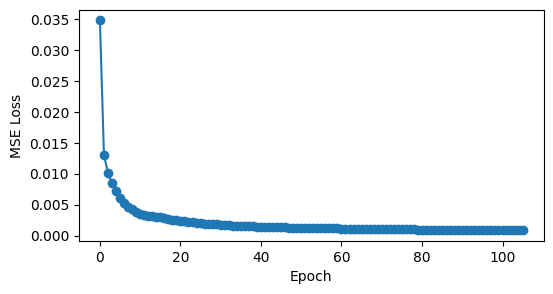

In [17]:
plt.figure(figsize=(6,3))
plt.plot(history,marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Inference & AUC

In [18]:
# Load best model for inference
checkpoint = torch.load('best_model.pt', map_location=DEVICE)
model = FCUnetAE().to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Inference and evaluation
scores, labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_dl, desc='Test'):  # evaluation
        x = x.to(DEVICE)
        recon = model(x)
        err = ((x - recon) ** 2).mean(dim=1).cpu().numpy()
        scores.extend(err)
        labels.extend(y.numpy())

auc = roc_auc_score(labels, scores)
print(f"Test AUC: {auc:.4f}")


Test: 100%|██████████| 3/3 [00:00<00:00, 10.47it/s]

Test AUC: 0.9328


## Error Distribution

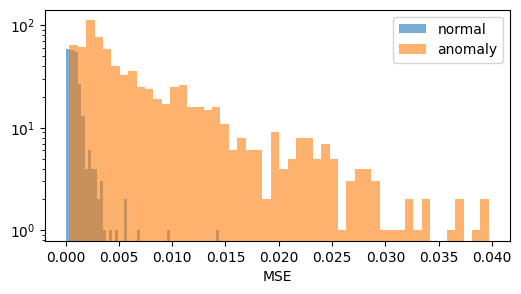

In [19]:
norm=[s for s,l in zip(scores,labels) if l==0]
anom=[s for s,l in zip(scores,labels) if l==1]
plt.figure(figsize=(6,3))
plt.hist(norm,bins=50,alpha=0.6,label='normal',log=True)
plt.hist(anom,bins=50,alpha=0.6,label='anomaly',log=True)
plt.xlabel('MSE')
plt.legend()
plt.show()